<a href="https://colab.research.google.com/github/Rizwankaka/Agentic-AI-/blob/main/Langgraph/module-5/5_03_memoryschema_collection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chatbot with Collection Schema
## Review
We extended our chatbot to save semantic memories to a single [user profile](https://langchain-ai.github.io/langgraph/concepts/memory/#profile).

We also introduced a library, [Trustcall](https://github.com/hinthornw/trustcall), to update this schema with new information.

## Goals

Sometimes we want to save memories to a [collection](https://docs.google.com/presentation/d/181mvjlgsnxudQI6S3ritg9sooNyu4AcLLFH1UK0kIuk/edit#slide=id.g30eb3c8cf10_0_200) rather than single profile.

Here we'll update our chatbot to [save memories to a collection](https://langchain-ai.github.io/langgraph/concepts/memory/#collection).

We'll also show how to use [Trustcall](https://github.com/hinthornw/trustcall) to update this collection.

In [1]:
%%capture --no-stderr
%pip install -U langchain_openai langgraph trustcall langchain_core

In [2]:
import os
from google.colab import userdata

os.environ["LANGCHAIN_API_KEY"] = userdata.get('LANGCHAIN_API_KEY')

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "langchain-academy"

## Defining a collection schema
Instead of storing user information in a fixed profile structure, we'll create a flexible collection schema to store memories about user interactions.

Each memory will be stored as a separate entry with a single `content` field for the main information we want to remember

This approach allows us to build an open-ended collection of memories that can grow and change as we learn more about the user.

We can define a collection schema as a [Pydantic](https://docs.pydantic.dev/latest/) object.

In [3]:
from pydantic import BaseModel, Field

class Memory(BaseModel):
    content: str = Field(description="The main content of the memory. For example: User expressed interest in learning about French.")

class MemoryCollection(BaseModel):
    memories: list[Memory] = Field(description="A list of memories about the user.")

In [4]:
os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')

We can used LangChain's chat model chat model interface's `with_structured_output` method to enforce structured output.

In [5]:
from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI

# Initialize the model
model = ChatOpenAI(model="gpt-4o-mini", temperature=0)

# Bind schema to model
model_with_structure = model.with_structured_output(MemoryCollection)

# Invoke the model to produce structured output that matches the schema
memory_collection = model_with_structure.invoke([HumanMessage("My name is Rizwan. I like to bike.")])
memory_collection.memories

[Memory(content="User's name is Rizwan."),
 Memory(content='User likes to bike.')]

We can use `model_dump()` to serialize a Pydantic model instance into a Python dictionary.

In [6]:
memory_collection.memories[0].model_dump()

{'content': "User's name is Rizwan."}

Save dictionary representation of each memory to the store.

In [7]:
import uuid
from langgraph.store.memory import InMemoryStore

# Initialize the in-memory store
in_memory_store = InMemoryStore()

# Namespace for the memory to save
user_id = "1"
namespace_for_memory = (user_id, "memories")

# Save a memory to namespace as key and value
key = str(uuid.uuid4())
value = memory_collection.memories[0].model_dump()
in_memory_store.put(namespace_for_memory, key, value)

key = str(uuid.uuid4())
value = memory_collection.memories[1].model_dump()
in_memory_store.put(namespace_for_memory, key, value)

Search for memories in the store.

In [8]:
# Search
for m in in_memory_store.search(namespace_for_memory):
    print(m.dict())

{'namespace': ['1', 'memories'], 'key': 'c8a528c0-d051-45bb-9c3f-5b19ee34e1c0', 'value': {'content': "User's name is Rizwan."}, 'created_at': '2025-01-11T14:47:41.516893+00:00', 'updated_at': '2025-01-11T14:47:41.516898+00:00', 'score': None}
{'namespace': ['1', 'memories'], 'key': 'b74a0822-85c3-4610-b495-aad34d38e7fd', 'value': {'content': 'User likes to bike.'}, 'created_at': '2025-01-11T14:47:41.517143+00:00', 'updated_at': '2025-01-11T14:47:41.517146+00:00', 'score': None}


## Updating collection schema
We discussed the challenges with updating a profile schema in the last lesson.

The same applies for collections!

We want the ability to update the collection with new memories as well as update existing memories in the collection.

Now we'll show that [Trustcall](https://github.com/hinthornw/trustcall) can be also used to update a collection.

This enables both addition of new memories as well as [updating existing memories in the collection](https://github.com/hinthornw/trustcall?tab=readme-ov-file#simultanous-updates--insertions).

Let's define a new extractor with Trustcall.

As before, we provide the schema for each memory, `Memory`.

But, we can supply `enable_inserts=True` to allow the extractor to insert new memories to the collection.

In [9]:
from trustcall import create_extractor

# Create the extractor
trustcall_extractor = create_extractor(
    model,
    tools=[Memory],
    tool_choice="Memory",
    enable_inserts=True,
)

In [10]:
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage

# Instruction
instruction = """Extract memories from the following conversation:"""

# Conversation
conversation = [HumanMessage(content="Hi, I'm Rizwan."),
                AIMessage(content="Nice to meet you, Rizwan."),
                HumanMessage(content="This morning I had a nice bike ride in Stuttgart.")]

# Invoke the extractor
result = trustcall_extractor.invoke({"messages": [SystemMessage(content=instruction)] + conversation})

In [11]:
# Messages contain the tool calls
for m in result["messages"]:
    m.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  Memory (call_6QoNf5Fcr0nIeBR2hP9poOIR)
 Call ID: call_6QoNf5Fcr0nIeBR2hP9poOIR
  Args:
    content: User had a nice bike ride in Stuttgart this morning.


In [12]:
# Responses contain the memories that adhere to the schema
for m in result["responses"]:
    print(m)

content='User had a nice bike ride in Stuttgart this morning.'


In [13]:
# Metadata contains the tool call
for m in result["response_metadata"]:
    print(m)

{'id': 'call_6QoNf5Fcr0nIeBR2hP9poOIR'}


In [14]:
# Update the conversation
updated_conversation = [AIMessage(content="That's great, did you do after?"),
                        HumanMessage(content="I went to Tartine and ate a croissant."),
                        AIMessage(content="What else is on your mind?"),
                        HumanMessage(content="I was thinking about my Japan, and going back this winter!"),]

# Update the instruction
system_msg = """Update existing memories and create new ones based on the following conversation:"""

# We'll save existing memories, giving them an ID, key (tool name), and value
tool_name = "Memory"
existing_memories = [(str(i), tool_name, memory.model_dump()) for i, memory in enumerate(result["responses"])] if result["responses"] else None
existing_memories

[('0',
  'Memory',
  {'content': 'User had a nice bike ride in Stuttgart this morning.'})]

In [15]:
# Invoke the extractor with our updated conversation and existing memories
result = trustcall_extractor.invoke({"messages": updated_conversation,
                                     "existing": existing_memories})

In [16]:
# Messages from the model indicate two tool calls were made
for m in result["messages"]:
    m.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  Memory (call_JljlgyZuWQKI6DpfiO8LsS0c)
 Call ID: call_JljlgyZuWQKI6DpfiO8LsS0c
  Args:
    content: User had a nice bike ride in Stuttgart this morning. User went to Tartine and ate a croissant. User is thinking about going back to Japan this winter.
  Memory (call_BnWajcdfD621w9KyOkNmxPEM)
 Call ID: call_BnWajcdfD621w9KyOkNmxPEM
  Args:
    content: User went to Tartine and ate a croissant.
  Memory (call_Nb6gcpzCRiowY2q7JNQgBglB)
 Call ID: call_Nb6gcpzCRiowY2q7JNQgBglB
  Args:
    content: User is thinking about going back to Japan this winter.


In [17]:
# Responses contain the memories that adhere to the schema
for m in result["responses"]:
    print(m)

content='User had a nice bike ride in Stuttgart this morning. User went to Tartine and ate a croissant. User is thinking about going back to Japan this winter.'
content='User went to Tartine and ate a croissant.'
content='User is thinking about going back to Japan this winter.'


In [18]:
# Metadata contains the tool call
for m in result["response_metadata"]:
    print(m)

{'id': 'call_JljlgyZuWQKI6DpfiO8LsS0c', 'json_doc_id': '0'}
{'id': 'call_BnWajcdfD621w9KyOkNmxPEM'}
{'id': 'call_Nb6gcpzCRiowY2q7JNQgBglB'}


LangSmith trace:

https://smith.langchain.com/public/fb237a32-8080-4cdc-ab02-7c8ae1d010e0/r

## Chatbot with collection schema updating
Now, let's bring Trustcall into our chatbot to create and update a memory collection.

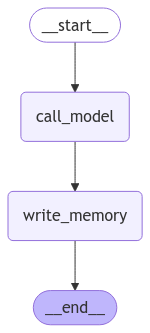

In [19]:

from IPython.display import Image, display

import uuid

from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.store.memory import InMemoryStore
from langchain_core.messages import merge_message_runs
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.runnables.config import RunnableConfig
from langgraph.checkpoint.memory import MemorySaver
from langgraph.store.base import BaseStore

# Initialize the model
model = ChatOpenAI(model="gpt-4o-mini", temperature=0)

# Memory schema
class Memory(BaseModel):
    content: str = Field(description="The main content of the memory. For example: User expressed interest in learning about French.")

# Create the Trustcall extractor
trustcall_extractor = create_extractor(
    model,
    tools=[Memory],
    tool_choice="Memory",
    # This allows the extractor to insert new memories
    enable_inserts=True,
)

# Chatbot instruction
MODEL_SYSTEM_MESSAGE = """You are a helpful chatbot. You are designed to be a companion to a user.

You have a long term memory which keeps track of information you learn about the user over time.

Current Memory (may include updated memories from this conversation):

{memory}"""

# Trustcall instruction
TRUSTCALL_INSTRUCTION = """Reflect on following interaction.

Use the provided tools to retain any necessary memories about the user.

Use parallel tool calling to handle updates and insertions simultaneously:"""

def call_model(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Load memories from the store and use them to personalize the chatbot's response."""

    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Retrieve memory from the store
    namespace = ("memories", user_id)
    memories = store.search(namespace)

    # Format the memories for the system prompt
    info = "\n".join(f"- {mem.value['content']}" for mem in memories)
    system_msg = MODEL_SYSTEM_MESSAGE.format(memory=info)

    # Respond using memory as well as the chat history
    response = model.invoke([SystemMessage(content=system_msg)]+state["messages"])

    return {"messages": response}

def write_memory(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Reflect on the chat history and update the memory collection."""

    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Define the namespace for the memories
    namespace = ("memories", user_id)

    # Retrieve the most recent memories for context
    existing_items = store.search(namespace)

    # Format the existing memories for the Trustcall extractor
    tool_name = "Memory"
    existing_memories = ([(existing_item.key, tool_name, existing_item.value)
                          for existing_item in existing_items]
                          if existing_items
                          else None
                        )

    # Merge the chat history and the instruction
    updated_messages=list(merge_message_runs(messages=[SystemMessage(content=TRUSTCALL_INSTRUCTION)] + state["messages"]))

    # Invoke the extractor
    result = trustcall_extractor.invoke({"messages": updated_messages,
                                        "existing": existing_memories})

    # Save the memories from Trustcall to the store
    for r, rmeta in zip(result["responses"], result["response_metadata"]):
        store.put(namespace,
                  rmeta.get("json_doc_id", str(uuid.uuid4())),
                  r.model_dump(mode="json"),
            )

# Define the graph
builder = StateGraph(MessagesState)
builder.add_node("call_model", call_model)
builder.add_node("write_memory", write_memory)
builder.add_edge(START, "call_model")
builder.add_edge("call_model", "write_memory")
builder.add_edge("write_memory", END)

# Store for long-term (across-thread) memory
across_thread_memory = InMemoryStore()

# Checkpointer for short-term (within-thread) memory
within_thread_memory = MemorySaver()

# Compile the graph with the checkpointer fir and store
graph = builder.compile(checkpointer=within_thread_memory, store=across_thread_memory)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [20]:
# We supply a thread ID for short-term (within-thread) memory
# We supply a user ID for long-term (across-thread) memory
config = {"configurable": {"thread_id": "1", "user_id": "1"}}

# User input
input_messages = [HumanMessage(content="Hi, my name is Rizwan")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Hi, my name is Rizwan
================================== Ai Message ==================================

Hi Rizwan! It's great to meet you. How's your day going?


In [23]:
# User input
input_messages = [HumanMessage(content="I like to bike around Stuttgart")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I like to bike around Stuttgart
================================== Ai Message ==================================

That's awesome! So you enjoy biking around Stuttgart as well. How does biking there compare to biking in San Francisco? Do you have any favorite routes or spots in Stuttgart?


In [24]:
# Namespace for the memory to save
user_id = "1"
namespace = ("memories", user_id)
memories = across_thread_memory.search(namespace)
for m in memories:
    print(m.dict())

{'namespace': ['memories', '1'], 'key': '5d1d9948-d1cf-4a44-a764-ff10b17cbb1e', 'value': {'content': "User's name is Rizwan. User enjoys biking around Stuttgart."}, 'created_at': '2025-01-11T14:57:38.335564+00:00', 'updated_at': '2025-01-11T14:57:38.335566+00:00', 'score': None}
{'namespace': ['memories', '1'], 'key': '5cc79d49-3906-4f88-aac7-e6e29799a75c', 'value': {'content': 'User enjoys biking around Stuttgart.'}, 'created_at': '2025-01-11T14:57:38.335591+00:00', 'updated_at': '2025-01-11T14:57:38.335592+00:00', 'score': None}


In [25]:
# User input
input_messages = [HumanMessage(content="I also enjoy going to bakeries")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I also enjoy going to bakeries
================================== Ai Message ==================================

Bakeries are such a treat! Do you have a favorite bakery in Stuttgart or San Francisco that you like to visit after a bike ride?


In [26]:
# We supply a thread ID for short-term (within-thread) memory
# We supply a user ID for long-term (across-thread) memory
config = {"configurable": {"thread_id": "2", "user_id": "1"}}

# User input
input_messages = [HumanMessage(content="What bakeries do you recommend for me?")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

What bakeries do you recommend for me?
================================== Ai Message ==================================

Since you enjoy going to bakeries, here are a few recommendations in Stuttgart and San Francisco:

**Stuttgart:**
1. **Bäckerei Schmid** - Known for their delicious pastries and traditional German breads.
2. **Café Rösterei** - A cozy spot with great coffee and a variety of baked goods, including cakes and tarts.
3. **Konditorei Café Duss** - Famous for their exquisite cakes and seasonal treats.

**San Francisco:**
1. **Tartine Bakery** - A must-visit for their artisanal bread and pastries, especially the morning buns.
2. **B Patisserie** - Known for their French pastries, including the famous kouign-amann.
3. **Miette Patisserie** - A charming bakery with beautiful cakes and confections.

Do any of these sound good to you?


## Langsmith

https://smith.langchain.com/public/8f7afa54-bd11-4cf7-a8f6-31624a735c99/r